# Basic tests with SimplePatternLearner module

In [1]:
import os
import torch
import matplotlib.pyplot as plt

from dataset.utils import load_pickle_data, save_dict
from ML.utils import correlation
from ML.architecture import SimplePatternLearner, Correlation_loss
from ripdalib.variations.transform import list_to_matrix, matrix_to_list
from ripdalib.variations.plot import plot_matrix, plot_correlation, plot_patterns_from_correlation

## Initiation

In [2]:
IMAGE = load_pickle_data(os.path.join("Fugues_data", "data.pkl"))["BWV_0846"]
MAX_EPOCH = 200
LEARNING_RATE = 0.1
EPSILON = 0.0001
PATTERN_MAXSIZE = (4*16, 10)

MINDIV = 16 #from Fugues_data.midi_to_pkl import MINDIV

torch.manual_seed(689)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
matrix_image = list_to_matrix(IMAGE, MINDIV)

In [11]:
module = SimplePatternLearner(PATTERN_MAXSIZE)
loss = Correlation_loss(beta=10000000, smooth_function=3, mean_size=10)

## Training

In [12]:
torch.manual_seed(689)
module.reset()
module.learn_pattern(matrix_image, loss, learning_rates=LEARNING_RATE, maxepoch=MAX_EPOCH, epsilon=EPSILON)

Training...:   4%|██▎                                               | 9/200 [00:02<00:47,  4.02it/s]

Current_loss = 370654144.0


Training...:  10%|████▋                                            | 19/200 [00:04<00:42,  4.25it/s]

Current_loss = 2756717.0


Training...:  14%|███████                                          | 29/200 [00:07<00:43,  3.97it/s]

Current_loss = 241914.625


Training...:  20%|█████████▌                                       | 39/200 [00:09<00:38,  4.16it/s]

Current_loss = 577537.0


Training...:  24%|████████████                                     | 49/200 [00:12<00:40,  3.71it/s]

Current_loss = 674666.0


Training...:  30%|██████████████▍                                  | 59/200 [00:14<00:34,  4.12it/s]

Current_loss = 703917.0625


Training...:  34%|████████████████▉                                | 69/200 [00:16<00:30,  4.36it/s]

Current_loss = 711218.4375


Training...:  40%|███████████████████▎                             | 79/200 [00:19<00:28,  4.19it/s]

Current_loss = 710470.25


Training...:  44%|█████████████████████▊                           | 89/200 [00:21<00:26,  4.25it/s]

Current_loss = 706449.375


Training...:  50%|████████████████████████▎                        | 99/200 [00:24<00:23,  4.25it/s]

Current_loss = 700877.125


Training...:  55%|██████████████████████████▏                     | 109/200 [00:26<00:21,  4.15it/s]

Current_loss = 694372.0625


Training...:  60%|████████████████████████████▌                   | 119/200 [00:29<00:20,  4.03it/s]

Current_loss = 687141.25


Training...:  64%|██████████████████████████████▉                 | 129/200 [00:31<00:17,  4.17it/s]

Current_loss = 679236.3125


Training...:  70%|█████████████████████████████████▎              | 139/200 [00:34<00:13,  4.36it/s]

Current_loss = 670647.9375


Training...:  74%|███████████████████████████████████▊            | 149/200 [00:36<00:12,  4.19it/s]

Current_loss = 661341.375


Training...:  80%|██████████████████████████████████████▏         | 159/200 [00:39<00:09,  4.19it/s]

Current_loss = 651268.0


Training...:  84%|████████████████████████████████████████▌       | 169/200 [00:41<00:07,  4.21it/s]

Current_loss = 640370.875


Training...:  90%|██████████████████████████████████████████▉     | 179/200 [00:44<00:05,  3.82it/s]

Current_loss = 628585.4375


Training...:  94%|█████████████████████████████████████████████▎  | 189/200 [00:46<00:02,  4.06it/s]

Current_loss = 615840.625


Training...: 100%|███████████████████████████████████████████████▊| 199/200 [00:49<00:00,  4.11it/s]

Current_loss = 602058.9375


Training...: 100%|████████████████████████████████████████████████| 200/200 [00:49<00:00,  4.05it/s]

Last loss : 600620.50000000


In [6]:
SAVE = True
FILE = "temp.pkl"

if SAVE:
    save_dict(module.state_dict(), FILE)
else:
    module.load_state_dict(load_pickle_data(FILE))

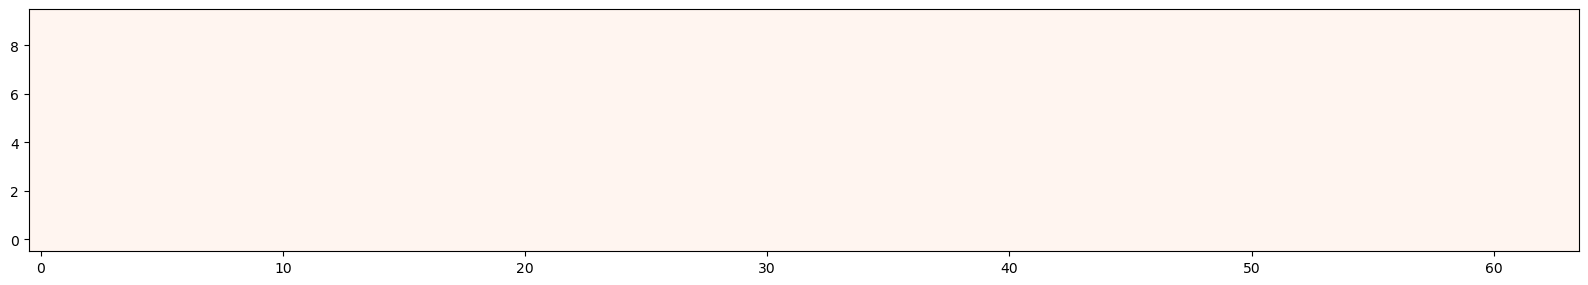

tensor(0.0038)


In [13]:
plot_correlation(module.pattern.squeeze((0,1)))
with torch.no_grad():
    print(torch.max(module.pattern))

In [8]:
print(torch.sum(module.pattern))
print(matrix_to_list(module.pattern.squeeze((0,1)) > 0.5, mindiv=MINDIV))

tensor(2.2594)
[]


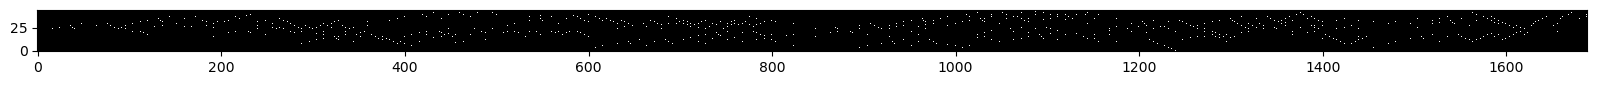

In [9]:
plot_matrix(matrix_image)

In [10]:
plot_patterns_from_correlation(module.correlation(matrix_image), IMAGE, module.pattern >0.5, threshold=0.4, quantization=MINDIV)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

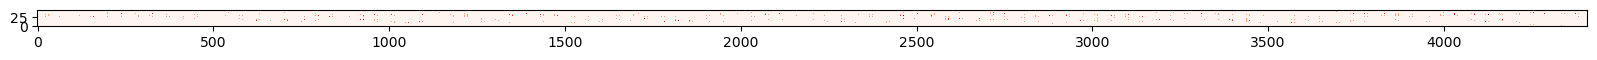

tensor(1.0000)


In [ ]:
plot_correlation(module.correlation(matrix_image).squeeze((0,1)))
with torch.no_grad():
    print(torch.max(module.correlation(matrix_image)))

## Loss behavior

- The interaction between beta and the smooth function is really sensitive.
- The basic kernel learns extreme value
- Positive beta give noise map
- High Negative beta give the one element, from 0 to -high we get a decrease number of points in the pattern, but often it does not have exact apparition even once in the original piece
- Beta does not seem to be correlated with the input neither the pattern size, but deeper investigation should be done. An adaptative beta during training could give results.
- Generally the training find a suddent "local minimum hole" and have a quick deacreasing before stopping. In a bigger training with mini-batch training, we may find a better minimum

Drawbacks :
- see this as an optiization problem is of course not optimal and create probable high instability
- Training on one example which must contain noise due to basic midi quantization (even if the files are mostly clean) must not be optimal.

Residuals : supprimer le pattern dominant et recommencer

Division d'un pattern en 2 avec les channels ?
Difference trop stricte ? #Future work, voir avec 1 seul déjà
Future path : PCA...